In [23]:
from trading_ig import IGService
from autoIG.config import ig_service_config,open_position_config_,close_position_config_
ig_service = IGService(**ig_service_config)
from autoIG.instruments import Epics
from autoIG.utils import mins_to_ms
from datetime import date
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import date
from datetime import timedelta

from autoIG.utils import TMP_DIR
create_session_responce = ig_service.create_session()
MINS_OF_TRANSACTIONS = 5020
NOW_DATE = datetime.now().date()




In [139]:
from datetime import timedelta
timedelta(minutes=11400).total_seconds() *1000

684000.0

In [140]:
transactions

,date,instrumentName,period,profitAndLoss,transactionType,reference,openLevel,closeLevel,size,currency,cashTransaction
0,03/01/23,Oil - US Crude,DFB,£-6.00,DEAL,DIAAAALHR5N8WA2,7965.9,7959.9,+1,£,False
1,03/01/23,Oil - US Crude,DFB,£1.90,DEAL,DIAAAALHR52WEBB,7960.2,7962.1,+1,£,False
2,03/01/23,Oil - US Crude,DFB,£18.50,DEAL,DIAAAALHR5GUVAM,7944.9,7963.4,+1,£,False
3,03/01/23,Oil - US Crude,DFB,£16.70,DEAL,DIAAAALHR5TF8AL,7945.7,7962.4,+1,£,False
4,03/01/23,Oil - US Crude,DFB,£9.90,DEAL,DIAAAALHR5Q2QAN,7946.2,7956.1,+1,£,False
...,...,...,...,...,...,...,...,...,...,...,...
122,03/01/23,Oil - US Crude,DFB,£8.20,DEAL,DIAAAALHJLU7TAN,7917.1,7925.3,+1,£,False
123,03/01/23,Oil - US Crude,DFB,£20.70,DEAL,DIAAAALHJLPK3AH,7907.6,7928.3,+1,£,False
124,03/01/23,Oil - US Crude,DFB,£39.20,DEAL,DIAAAALHJL95EA6,7863.9,7903.1,+1,£,False
125,03/01/23,Oil - US Crude,DFB,£37.00,DEAL,DIAAAALHJLPETAH,7866.1,7903.1,+1,£,False


In [24]:
transactions = ig_service.fetch_transaction_history_by_type_and_period(
    trans_type='ALL_DEAL',
    milliseconds=mins_to_ms(MINS_OF_TRANSACTIONS)
    )
print(transactions.head(1))

activity = ig_service.fetch_account_activity(
    from_date=NOW_DATE - timedelta(days =3),
    to_date=NOW_DATE + timedelta(days =1),
    detailed=True,
    )

print(activity.head(1))

In [67]:
transactions_filtered = transactions.drop(
    # Drop this date since activity date is more acurate
    ["date", "period", "transactionType", "cashTransaction"],
    axis=1,
)
transactions_filtered = transactions_filtered.rename(
    columns={"reference": "closing_dealId"}
).astype({"openLevel": float, "closeLevel": float})
transactions_filtered = transactions_filtered[
    [
        "closing_dealId",
        "instrumentName",
        "openLevel",
        "closeLevel",
        "size",
        "profitAndLoss",
        "currency",
    ]
]
transactions_filtered.head(3)


,closing_dealId,instrumentName,openLevel,closeLevel,size,profitAndLoss,currency
0,DIAAAALHR5N8WA2,Oil - US Crude,7965.9,7959.9,+1,£-6.00,£
1,DIAAAALHR52WEBB,Oil - US Crude,7960.2,7962.1,+1,£1.90,£
2,DIAAAALHR5GUVAM,Oil - US Crude,7944.9,7963.4,+1,£18.50,£


In [68]:
## WE ARE ONLY LOOKING AT SELL ACTIVITY
sell_activity_filtered = activity[activity.direction == "SELL"][
    [
        "date",
        # "epic",
        "dealId",
        "affectedDealId",
    ]
]
sell_activity_filtered = sell_activity_filtered.rename(
    columns={
        "dealId": "closing_dealId",
        "affectedDealId": "opening_dealId",
        "date": "sell_date",
    }
)
sell_activity_filtered.sell_date = pd.to_datetime(sell_activity_filtered.sell_date)
sell_activity_filtered = sell_activity_filtered[
    [
        "opening_dealId",  # We get this from the affected deal
        "closing_dealId",  # They all have closing deal IDs because we filtered direction==SELL and size =1.0 for all
        "sell_date",
        # "epic",
    ]
]
sell_activity_filtered.head(3)

# Maybe we could get the buy_date from the opening_dealId in activity
buy_activity_filtered = activity[activity.direction == "BUY"][
    [
        "date",
        "dealId",
        # "affectedDealId",
    ]
].rename(
    columns={
        "dealId": "opening_dealId",
        "date": "buy_date",
    }
)

activity_filtered = sell_activity_filtered.merge(buy_activity_filtered, on = 'opening_dealId')
activity_filtered.head(1)


,opening_dealId,closing_dealId,sell_date,buy_date
0,DIAAAALHR5DL4AP,DIAAAALHR5N8WA2,2023-01-03 13:17:02,2023-01-03T13:14:00
1,DIAAAALHR55TYAK,DIAAAALHR52WEBB,2023-01-03 13:16:00,2023-01-03T13:13:01
2,DIAAAALHR5X3LAY,DIAAAALHR5GUVAM,2023-01-03 13:15:01,2023-01-03T13:12:00
3,DIAAAALHR5JDNA6,DIAAAALHR5TF8AL,2023-01-03 13:14:00,2023-01-03T13:11:01
4,DIAAAALHR5L6VAW,DIAAAALHR5Q2QAN,2023-01-03 13:13:02,2023-01-03T13:10:00
...,...,...,...,...
94,DIAAAALHJL6B8AQ,DIAAAALHJL8Z8AV,2023-01-03 11:18:00,2023-01-03T11:15:01
95,DIAAAALHJLHVXA5,DIAAAALHJMUBRBC,2023-01-03 11:17:00,2023-01-03T11:14:01
96,DIAAAALHJMCN9AX,DIAAAALHJL6EEAQ,2023-01-03 11:16:00,2023-01-03T11:13:00
97,DIAAAALHJLN3YA7,DIAAAALHJLU7TAN,2023-01-03 11:15:01,2023-01-03T11:12:01


In [69]:
position_metrics = pd.read_csv(TMP_DIR / "position_metrics.csv")
position_metrics = position_metrics.rename(columns={"dealId": "opening_dealId"})
position_metrics = position_metrics[
    [
        # "dealreference",
        "opening_dealId",
        "prediction",
        "model_used",
        # "buy_date", # Maybe this should be renamed to buy_date_real or something and there should be some maning consistency
    ]
]
position_metrics.head(3)


,opening_dealId,prediction,model_used
0,DIAAAALGJ9Y6SAG,1.000177,/Users/ezracitron/my_projects/auto_IG/mlruns/9...
1,DIAAAALGKCGR6AY,1.000125,/Users/ezracitron/my_projects/auto_IG/mlruns/9...
2,DIAAAALGKBR5RAN,1.000177,/Users/ezracitron/my_projects/auto_IG/mlruns/9...


In [76]:
joined = transactions_filtered.merge(activity_filtered, left_on='closing_dealId',right_on='closing_dealId').merge(position_metrics,left_on='opening_dealId',right_on='opening_dealId')
joined['actual'] = joined['closeLevel']/ joined['openLevel']
joined['profitAndLoss_numeric'] = joined['profitAndLoss'].str.removeprefix('£').astype(float)
reorder = [
    "sell_date",
    "buy_date",
    # "epic",
    "opening_dealId",
    "closing_dealId",
    "openLevel",
    "closeLevel",
    "instrumentName",
    "profitAndLoss",
    'profitAndLoss_numeric',
    "size",
    "currency",
    # "dealreference",
    "model_used",
    "prediction",
    'actual'
]
print(joined.shape)
print(joined[reorder].shape)
joined = joined[reorder]
joined = joined.set_index('sell_date')#.profitAndLoss_numeric#.cumsum()
joined = joined.sort_index(ascending=True)
print(joined.index.min())
print(joined.index.max())
joined.to_csv('../autoIG/resources/tmp/transactions_joined.csv')
joined.head(3)


(99, 14)
(99, 14)
2023-01-03 11:14:01
2023-01-03 13:17:02


,buy_date,opening_dealId,closing_dealId,openLevel,closeLevel,instrumentName,profitAndLoss,profitAndLoss_numeric,size,currency,model_used,prediction,actual
sell_date,,,,,,,,,,,,,
2023-01-03 11:14:01,2023-01-03T11:11:01,DIAAAALHJLJNQBB,DIAAAALHJLPK3AH,7907.6,7928.3,Oil - US Crude,£20.70,20.7,+1,£,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000112,1.002618
2023-01-03 11:15:01,2023-01-03T11:12:01,DIAAAALHJLN3YA7,DIAAAALHJLU7TAN,7917.1,7925.3,Oil - US Crude,£8.20,8.2,+1,£,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000493,1.001036
2023-01-03 11:16:00,2023-01-03T11:13:00,DIAAAALHJMCN9AX,DIAAAALHJL6EEAQ,7927.1,7929.1,Oil - US Crude,£2.00,2.0,+1,£,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000688,1.000252


In [ ]:
## Vis

In [15]:
for i,df in joined.groupby('opening_dealId'):
    pass

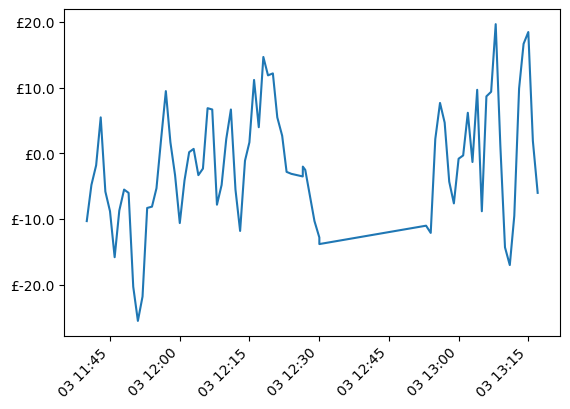

In [16]:
# Profit over time for a each model
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
def update_ticks(x, pos):
    return 1
fig,ax = plt.subplots(1,1)
# ax.plot(joined.profitAndLoss_numeric)
for v,df in joined.groupby('model_used'):
    ax.plot(df.profitAndLoss_numeric)
fig.autofmt_xdate(rotation=45)
ax.yaxis.set_major_formatter(mticker.FuncFormatter( lambda x,pos: "£"+str(x))  )



In [10]:
import sqlite3
from autoIG.utils import TMP_DIR
import pandas as pd
with sqlite3.connect(TMP_DIR/'autoIG.sqlite') as sqliteConnection:
        # Maybe open and close connection only once at the begining and end?
        # Or wrap everthing in a context manager
        print("Database created and Successfully Connected to SQLite")
        df = pd.read_sql("select * from to_sell",con=sqliteConnection)
df


Database created and Successfully Connected to SQLite


,index,dealId,to_sell_date,sold
0,0,DIAAAALG2ADNAAM,2022-12-30 08:32:00,1
1,1,DIAAAALGZ9475AQ,2022-12-30 08:33:00,1
2,2,DIAAAALGZ9V26AP,2022-12-30 08:34:00,1
3,3,DIAAAALG2AFVMBD,2022-12-30 08:35:00,1
4,4,DIAAAALG2AJXMAL,2022-12-30 08:36:00,1
...,...,...,...,...
498,247,DIAAAALJRCLCDAG,2023-01-06 09:26:00,1
499,248,DIAAAALJRCWTQA4,2023-01-06 09:27:00,0
500,249,DIAAAALJRCZWUBD,2023-01-06 09:28:00,0
501,250,DIAAAALJRCVCPAL,2023-01-06 09:28:00,0
